In [1]:
%load_ext autoreload
%autoreload 2

### Reproducibility statement

This notebook relies on data generated by code in the `l5pc` folder. In particular, we will simply load from file the following objects or datasets:
- TSNPE posteriors after the first round and final round
- 1000 prior samples and prior predictives (in order to run SBCC after round 1)
- the observed data $x_o$

### Code

In [2]:
from l5pc.utils.simulation_utils import assemble_prior, assemble_simulator
import dill
import pickle
import torch
from l5pc.model import (
    Priorl5pc,
    simulate_l5pc,
    setup_l5pc,
    summstats_l5pc,
    setup_l5pc,
)
from os.path import join
from sbi.analysis import pairplot
from l5pc.model.utils import return_gt, return_x_names, return_names
import numpy as np
from torch import as_tensor, ones, zeros, eye, float32
from l5pc.utils.common_utils import load_posterior
from l5pc.model.utils import return_gt, return_names, return_xo
from sbi.utils import BoxUniform
from sbi.utils.support_posterior import PosteriorSupport
from omegaconf import DictConfig
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


from l5pc.utils.common_utils import (
    load_prior,
    extract_bounds,
    load_posterior,
)
from l5pc.utils.evaluation_utils import (
    predictive_traces,
    plot_traces,
    plot_summstats,
    compare_gt_log_probs,
    gt_log_prob,
    coverage,
    plot_coverage,
)

In [3]:
setup_l5pc()

Loading neuron libraries
Successfully loaded libraries!


## Panel A

## Panel B

In [4]:
theta = return_gt()

In [5]:
trace = simulate_l5pc(theta)

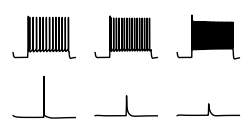

In [6]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 3, figsize=(3, 1.5))
    ax[1, 0].plot(trace[0]['bAP.soma.v']["time"], trace[0]['bAP.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[1, 1].plot(trace[0]['bAP.dend1.v']["time"], trace[0]['bAP.dend1.v']["voltage"], c="k", linewidth=1.0)
    ax[1, 2].plot(trace[0]['bAP.dend2.v']["time"], trace[0]['bAP.dend2.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 0].plot(trace[0]['Step1.soma.v']["time"], trace[0]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 1].plot(trace[0]['Step2.soma.v']["time"], trace[0]['Step2.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 2].plot(trace[0]['Step3.soma.v']["time"], trace[0]['Step3.soma.v']["voltage"], c="k", linewidth=1.0)
    
    for i in range(2):
        for j in range(3):
            ax[i, j].set_xticks([])
            ax[i, j].set_ylim([-90, 50])
            ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].spines["left"].set_visible(False)
            ax[i, j].spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_b.svg")

## Panel C

In [5]:
prior = assemble_prior(DictConfig({"model": {"name": "l5pc", "num_params": 20, "prior": [[]]}}))

In [8]:
_ = torch.manual_seed(0)
theta = prior.sample((4,))
trace = simulate_l5pc(theta, protocol_subset=["Step1"])

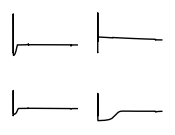

In [9]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 2, figsize=(2.0, 1.5))
    ax[0, 0].plot(trace[0]['Step1.soma.v']["time"], trace[0]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 1].plot(trace[1]['Step1.soma.v']["time"], trace[1]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[1, 0].plot(trace[2]['Step1.soma.v']["time"], trace[2]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[1, 1].plot(trace[3]['Step1.soma.v']["time"], trace[3]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    
    for i in range(2):
        for j in range(2):
            ax[i, j].set_xticks([])
            ax[i, j].set_ylim([-90, 50])
            ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].spines["left"].set_visible(False)
            ax[i, j].spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_c.svg")

## Panel D

### Loading simulations from disk

In Fig. 6, panel D, we run SBCC after the first round of TSNPE. This requires prior predictive samples. Below, we load prior samples and their simulation outputs from two pickle files. The commented cell above is the code we used to obtain these pickle files. Running that code requires to set up the database server, see the [README of the repo](https://github.com/mackelab/tsnpe_neurips/blob/main/README.md).

In [6]:
# from l5pc.model.table_definitions import L5PC_20D_theta, L5PC_20D_x
# from l5pc.utils.model_utils import (
#     replace_nan,
#     add_observation_noise,
# )

# x_db = L5PC_20D_x()
# theta_db = L5PC_20D_theta()

# data_id = "l20_0"
# round_ = 1
# theta = as_tensor(
#     np.asarray(
#         (theta_db & {"round": round_} & {"id": data_id}).fetch(*return_names())
#     ),
#     dtype=float32,
# ).T
# x = as_tensor(
#     np.asarray(
#         (x_db & {"round": round_} & {"id": data_id}).fetch(*return_x_names())
#     ),
#     dtype=float32,
# ).T

# x_pd = pd.DataFrame(x[-10000:].numpy(), columns=return_x_names())

# _ = torch.manual_seed(0)
# x = x[-1000:]
# theta = theta[-1000:]
# x, _ = replace_nan(x)
# x = add_observation_noise(
#     x=x,
#     id_=data_id,
#     noise_multiplier=0.0,
#     std_type="data",
#     subset=None,
# )

# with open("../../results/prior_sbcc_theta.pkl", "wb") as handle:
#     pickle.dump(theta, handle)
# with open("../../results/prior_sbcc_x.pkl", "wb") as handle:
#     pickle.dump(x, handle)

In [7]:
with open("../../results/prior_sbcc_theta.pkl", "rb") as handle:
    theta = pickle.load(handle)
with open("../../results/prior_sbcc_x.pkl", "rb") as handle:
    x = pickle.load(handle)

### Running SBCC after Round 1

In [14]:
base_path = "../../../l5pc/"
path = "2022_04_27__19_06_37_snpe"
inference_path = join(base_path, f"results/l20_7/inference/{path}")
with open(join(inference_path, "inference.pkl"), "rb") as handle:
    inferences = dill.load(handle)
with open(join(inference_path, "xo.pkl"), "rb") as handle:
    xo = pickle.load(handle)
xo = as_tensor(xo, dtype=float32)
posteriors = [infer.build_posterior().set_default_x(xo) for infer in inferences]

In [15]:
_ = torch.manual_seed(0)
alphas = []
covs = []
for i in range(10):
    alpha, cov = coverage(posteriors[i], theta, x, np.arange(35))
    alphas.append(alpha)
    covs.append(cov)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/michael/anaconda3/envs/tsnpe_neurips/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  outputs, _ = torch.triangular_solve(


  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

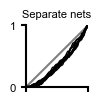

In [16]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.8, 0.8))
    ax.plot([0, 1.0], [0, 1.0], c="grey")
    for i in range(10):
        ax.plot(alphas[i], covs[i], c="k", linewidth=1.0)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticklabels([])
    ax.set_title("Separate nets")
    plt.savefig("../svg/panel_c1.svg")

In [17]:
inference, posterior, used_features, round_ = load_posterior("l20_7", "2022_04_27__19_06_37_snpe")

In [18]:
_ = torch.manual_seed(0)
alpha_ens, cov_ens = coverage(posterior, theta, x, used_features)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

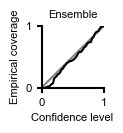

In [19]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.8, 0.8))
    ax.plot([0, 1.0], [0, 1.0], c="grey")
    ax.plot(alpha_ens, cov_ens, c="k")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Empirical coverage")
    ax.set_title("Ensemble")
    plt.savefig("../svg/panel_c2.svg", transparent=True)

## Panel E

In [8]:
inference, posterior, used_features, round_ = load_posterior("l20_7", "2022_05_08__08_59_11_snpe")

In [9]:
prior_bounds = extract_bounds(prior).T.numpy()

In [10]:
all_labels = []
for dim_i in range(4):
    labels = [prior_bounds[dim_i, num_tmp] for num_tmp in range(2)]
    new_labels = []
    counter = 0
    for l in labels:
        if counter == 0:
            new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$  ')
        else:
            new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$   ')
        counter+=1
    all_labels.append(new_labels)

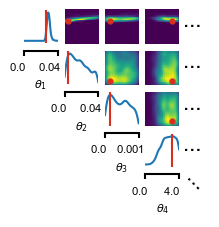

In [59]:
_ = torch.manual_seed(0)
posterior_samples = posterior.sample((1000,), show_progress_bars=False)
with mpl.rc_context(fname="../../.matplotlibrc"):
    _ = pairplot(
        posterior_samples,
        limits=prior_bounds,
        subset=[0, 1, 2, 3],
        upper=["kde"],
        diag=["kde"],
        ticks=prior_bounds,
        figsize=(2,2),
        labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"],
        tick_labels=all_labels,
        points=return_gt(as_pd=False),
        points_colors=["#d7301f"],
        points_offdiag={"markersize": 7}
    )
    plt.savefig("../svg/panel_d.svg")

## Panel F

In [32]:
_ = torch.manual_seed(1)
theta = posterior.sample((3,))
theta = pd.DataFrame(theta.numpy(), columns=return_names())
trace = simulate_l5pc(theta, protocol_subset=["Step1"])

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

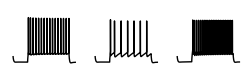

In [33]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(3, 0.75))
    ax[0].plot(trace[0]['Step1.soma.v']["time"], trace[0]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[1].plot(trace[1]['Step1.soma.v']["time"], trace[1]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[2].plot(trace[2]['Step1.soma.v']["time"], trace[2]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    
    for j in range(3):
        ax[j].set_xticks([])
        ax[j].set_ylim([-90, 50])
        ax[j].set_yticks([])
        ax[j].set_yticklabels([])
        ax[j].spines["left"].set_visible(False)
        ax[j].spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_e.svg")

## Panel G

In [34]:
_ = torch.manual_seed(7)
theta = posterior.sample((1,))
theta = pd.DataFrame(theta.numpy(), columns=return_names())
trace = simulate_l5pc(theta)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

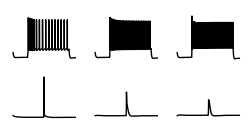

In [35]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 3, figsize=(3, 1.5))
    ax[1, 0].plot(trace[0]['bAP.soma.v']["time"], trace[0]['bAP.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[1, 1].plot(trace[0]['bAP.dend1.v']["time"], trace[0]['bAP.dend1.v']["voltage"], c="k", linewidth=1.0)
    ax[1, 2].plot(trace[0]['bAP.dend2.v']["time"], trace[0]['bAP.dend2.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 0].plot(trace[0]['Step1.soma.v']["time"], trace[0]['Step1.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 1].plot(trace[0]['Step2.soma.v']["time"], trace[0]['Step2.soma.v']["voltage"], c="k", linewidth=1.0)
    ax[0, 2].plot(trace[0]['Step3.soma.v']["time"], trace[0]['Step3.soma.v']["voltage"], c="k", linewidth=1.0)
    
    for i in range(2):
        for j in range(3):
            ax[i, j].set_xticks([])
            ax[i, j].set_ylim([-90, 50])
            ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].spines["left"].set_visible(False)
            ax[i, j].spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_f.svg")

In [36]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [60]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("15.7cm", "9.3cm",

    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale).move(0, 0),
          Text("a", -50, -8.0, **kwargs_text),
        Text("Morphology", -14, -8.0, **kwargs_text8pt),
    ).move(50, 20),
    Panel(
          SVG("../svg/panel_b.svg").scale(svg_scale).move(0, 0),
        Text("Step 1", 29, 13.0, **kwargs_text8pt),
        Text("Step 2", 102, 13.0, **kwargs_text8pt),
        Text("Step 3", 177, 13.0, **kwargs_text8pt),
        Text("bAP soma", 19, 68.0, **kwargs_text8pt),
        Text("bAP dend. 1", 82, 68.0, **kwargs_text8pt),
        Text("bAP dend. 2", 160, 68.0, **kwargs_text8pt),
        Text("Observation", 90, -1.0, **kwargs_text8pt),
        Text("b", -0, -1.0, **kwargs_text),
    ).move(140, 13),
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale).move(0, 0),
          Text("c", -10, -1.0, **kwargs_text),
        Text("Four Prior predictives for Step 1", 7, -1.0, **kwargs_text8pt),
    ).move(440, 13),
    Panel(
          SVG("../svg/panel_c1.svg").scale(svg_scale).move(0, 0),
          Text("d", -15, 16.0, **kwargs_text),
    ).move(15, 137),
    Panel(
          SVG("../svg/panel_c2.svg").scale(svg_scale).move(0, 0),
    ).move(0, 230),
    Panel(
          SVG("../svg/panel_d.svg").scale(svg_scale).move(0, 0),
          Text("e", 0, 3.0, **kwargs_text),
        Text("Posterior distribution", 50, 3.0, **kwargs_text8pt),
    ).move(140, 150),
    Panel(
          SVG("../svg/panel_e.svg").scale(svg_scale).move(0, 0),
          Text("f", 0, 4.0, **kwargs_text),
        Text("Three Posterior predictives for Step 1", 30, 4.0, **kwargs_text8pt),
    ).move(370, 149),
    Panel(
          SVG("../svg/panel_f.svg").scale(svg_scale).move(0, 0),
        Text("Step 1", 29, 13.0, **kwargs_text8pt),
        Text("Step 2", 102, 13.0, **kwargs_text8pt),
        Text("Step 3", 177, 13.0, **kwargs_text8pt),
        Text("bAP soma", 19, 68.0, **kwargs_text8pt),
        Text("bAP dend. 1", 82, 68.0, **kwargs_text8pt),
        Text("bAP dend. 2", 160, 68.0, **kwargs_text8pt),
        Text("Posterior predictive", 70, -2.0, **kwargs_text8pt),
          Text("g", 0, -2.0, **kwargs_text),
    ).move(370, 235),
)

f.save("../fig/fig5.svg")
svg('../fig/fig5.svg')